# Combined Oracle Bandits

Analyze the performance of various oracle bandits that solve the combined activity and matching task

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import json 
import argparse 
import sys

In [36]:
from rmab.simulator import RMABSimulator, random_valid_transition, random_valid_transition_round_down, synthetic_transition_small_window
from rmab.uc_whittle import UCWhittle, UCWhittleFixed, UCWhittleMatch, NormPlusMatch
from rmab.ucw_value import UCWhittle_value
from rmab.baselines import optimal_policy, random_policy, WIQL, optimal_match_slow_policy
from rmab.fr_dynamics import get_all_transitions
from rmab.utils import get_save_path, delete_duplicate_results


In [7]:
is_jupyter = 'ipykernel' in sys.modules

In [20]:
if is_jupyter: 
    seed        = 42
    n_arms      = 4
    budget      = 3 
    discount    = 0.9
    alpha       = 3 
    n_episodes  = 30
    episode_len = 20 
    n_epochs    = 10
    save_name = 'combined_lamb'
    match_prob = 0.5
    save_with_date = False 
else:
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_arms',         '-N', help='num beneficiaries (arms)', type=int, default=8)
    parser.add_argument('--episode_len',    '-H', help='episode length', type=int, default=20)
    parser.add_argument('--n_episodes',     '-T', help='num episodes', type=int, default=30)
    parser.add_argument('--budget',         '-B', help='budget', type=int, default=3)
    parser.add_argument('--n_epochs',       '-E', help='number of epochs (num_repeats)', type=int, default=10)
    parser.add_argument('--discount',       '-d', help='discount factor', type=float, default=0.9)
    parser.add_argument('--alpha',          '-a', help='alpha: for conf radius', type=float, default=3)
    parser.add_argument('--seed',           '-s', help='random seed', type=int, default=42)
    parser.add_argument('--save_name',      '-n', help='save name', type=str, default='combined_lamb')
    parser.add_argument('--match_prob',      '-m', help='match probability', type=float, default=0.5)
    parser.add_argument('--use_date', action='store_true')

    args = parser.parse_args()

    n_arms      = args.n_arms
    budget      = args.budget
    discount    = args.discount
    alpha       = args.alpha 
    seed        = args.seed
    n_episodes  = args.n_episodes
    episode_len = args.episode_len
    n_epochs    = args.n_epochs
    save_name   = args.save_name 
    save_with_date = args.use_date 
    match_prob = args.match_prob 



In [21]:
n_states = 2
n_actions = 2

In [22]:
all_population_size = 100 # number of random arms to generate
all_transitions = get_all_transitions(all_population_size)

In [23]:
all_transitions.shape

(100, 2, 2, 2)

In [24]:
all_features = np.arange(all_population_size)

In [25]:
np.random.seed(seed)
random.seed(seed)
simulator = RMABSimulator(all_population_size, all_features, all_transitions,
            n_arms, episode_len, n_epochs, n_episodes, budget, number_states=n_states, reward_style='match',match_probability=match_prob)

acting should always be good! 0.000 < 0.044
acting should always be good! 0.000 < 0.162
acting should always be good! 0.108 < 0.183
good start state should always be good! 0.380 < 0.508
good start state should always be good! 0.506 < 0.760
cohort [83 53 70 45]
cohort [41 39 15 76]
cohort [79 72 62 94]
cohort [92 64 85 36]
cohort [ 7 38 78  2]
cohort [12 59 91 73]
cohort [48 64  7 37]
cohort [18 53 12 32]
cohort [69 64 53 61]
cohort [46 87 15 26]


In [26]:
rewards_by_lamb = {}
std_by_lamb = {}
active_rates_by_lamb = {}

In [27]:
lamb = 0.5 

In [69]:
np.random.seed(seed)
random.seed(seed)
optimal_reward = optimal_policy(simulator, n_episodes, n_epochs, discount)
optimal_active_rate = simulator.total_active/(optimal_reward.size*n_arms)

first state [0 1 1 1]
   state [0 1 1 1] state_WI [0.39 0.47 0.47 0.26] sorted [2 1 0]
   state [1 1 1 0] state_WI [0.26 0.47 0.47 0.71] sorted [3 2 1]
   state [0 1 1 1] state_WI [0.39 0.47 0.47 0.26] sorted [2 1 0]
   state [1 1 0 1] state_WI [0.26 0.47 0.58 0.26] sorted [2 1 0]
   state [0 1 0 0] state_WI [0.39 0.47 0.58 0.71] sorted [3 2 1]
   state [1 1 1 1] state_WI [0.26 0.47 0.47 0.26] sorted [2 1 0]
   state [1 1 1 1] state_WI [0.26 0.47 0.47 0.26] sorted [2 1 0]
   state [0 1 1 0] state_WI [0.39 0.47 0.47 0.71] sorted [3 2 1]
   state [0 0 1 1] state_WI [0.39 0.54 0.47 0.26] sorted [1 2 0]
   state [1 1 1 1] state_WI [0.26 0.47 0.47 0.26] sorted [2 1 0]
   state [1 1 1 1] state_WI [0.26 0.47 0.47 0.26] sorted [2 1 0]
   state [1 1 1 0] state_WI [0.26 0.47 0.47 0.71] sorted [3 2 1]
   state [1 0 1 1] state_WI [0.26 0.54 0.47 0.26] sorted [1 2 0]
   state [1 1 0 0] state_WI [0.26 0.47 0.58 0.71] sorted [3 2 1]
   state [1 1 0 1] state_WI [0.26 0.47 0.58 0.26] sorted [2 1 0]
   

In [33]:
np.random.seed(seed)
random.seed(seed)
optimal_match_reward = optimal_match_slow_policy(simulator, n_episodes, n_epochs, discount)
optimal_match_active_rate = simulator.total_active/(optimal_match_reward.size*n_arms)
np.mean(optimal_match_reward)

first state [0 1 1 1]
instance 0, ep 1, state [1 1 1 1]
instance 0, ep 2, state [0 0 0 1]
instance 0, ep 3, state [1 1 0 1]
instance 0, ep 4, state [0 1 1 1]
instance 0, ep 5, state [0 0 0 1]
instance 0, ep 6, state [0 0 0 1]
instance 0, ep 7, state [0 1 1 0]
instance 0, ep 8, state [1 1 0 1]
instance 0, ep 9, state [1 1 1 1]
instance 0, ep 10, state [0 0 0 0]
instance 0, ep 11, state [0 1 0 0]
instance 0, ep 12, state [0 1 0 1]
instance 0, ep 13, state [0 0 0 0]
instance 0, ep 14, state [1 0 1 0]
instance 0, ep 15, state [0 0 0 1]
instance 0, ep 16, state [0 0 0 0]
instance 0, ep 17, state [1 1 0 1]
instance 0, ep 18, state [0 1 0 0]
instance 0, ep 19, state [0 1 1 1]
instance 0, ep 20, state [0 1 1 0]
instance 0, ep 21, state [0 0 1 0]
instance 0, ep 22, state [1 0 1 1]
instance 0, ep 23, state [0 1 1 1]
instance 0, ep 24, state [0 0 1 1]
instance 0, ep 25, state [0 0 1 0]
instance 0, ep 26, state [1 1 1 1]
instance 0, ep 27, state [0 1 1 0]
instance 0, ep 28, state [0 1 1 0]
instanc

0.7490833333333333

In [34]:
np.mean(optimal_match_reward + lamb*(optimal_active_rate*n_arms))

1.9365000000000006

In [38]:
np.random.seed(seed)
random.seed(seed)
joint_match_reward = optimal_match_slow_policy(simulator, n_episodes, n_epochs, discount,lamb=lamb)
joint_match_active_rate = simulator.total_active/(joint_match_reward.size*n_arms)
np.mean(joint_match_reward)

first state [0 1 1 1]
instance 0, ep 1, state [1 1 1 1]
instance 0, ep 2, state [0 0 0 1]
instance 0, ep 3, state [1 1 0 1]
instance 0, ep 4, state [0 1 1 1]
instance 0, ep 5, state [0 0 0 1]
instance 0, ep 6, state [0 0 0 1]
instance 0, ep 7, state [0 1 1 0]
instance 0, ep 8, state [1 1 0 1]
instance 0, ep 9, state [1 1 1 1]
instance 0, ep 10, state [0 0 0 0]
instance 0, ep 11, state [0 1 0 0]
instance 0, ep 12, state [0 1 0 1]
instance 0, ep 13, state [0 0 0 0]
instance 0, ep 14, state [1 0 1 0]
instance 0, ep 15, state [0 0 0 1]
instance 0, ep 16, state [0 0 0 0]
instance 0, ep 17, state [1 1 0 1]
instance 0, ep 18, state [0 1 0 0]
instance 0, ep 19, state [0 1 1 1]
instance 0, ep 20, state [0 1 1 0]
instance 0, ep 21, state [0 0 1 0]
instance 0, ep 22, state [1 0 1 1]
instance 0, ep 23, state [0 1 1 1]
instance 0, ep 24, state [0 0 1 1]
instance 0, ep 25, state [0 0 1 0]
instance 0, ep 26, state [1 1 1 1]
instance 0, ep 27, state [0 1 1 0]
instance 0, ep 28, state [0 1 1 0]
instanc

0.7404791666666667

In [39]:
np.mean(joint_match_reward + lamb*(joint_match_active_rate*n_arms))

1.9102291666666666

In [40]:
np.random.seed(seed)
random.seed(seed)
approximate_combined_reward = optimal_policy(simulator, n_episodes, n_epochs, discount,use_lamb=True,lamb=lamb)
approximate_combined_active_rate = simulator.total_active/(approximate_combined_reward.size*n_arms)

first state [0 1 1 1]
   state [0 1 1 1] state_WI [0.53 1.   1.   1.  ] sorted [3 2 1]
   state [1 1 1 0] state_WI [1.   1.   1.   0.78] sorted [2 1 0]
   state [0 1 1 0] state_WI [0.53 1.   1.   0.78] sorted [2 1 3]
   state [0 1 0 1] state_WI [0.53 1.   0.81 1.  ] sorted [3 1 2]
   state [0 1 0 1] state_WI [0.53 1.   0.81 1.  ] sorted [3 1 2]
   state [1 1 1 1] state_WI [1. 1. 1. 1.] sorted [3 2 1]
   state [1 1 1 1] state_WI [1. 1. 1. 1.] sorted [3 2 1]
   state [0 1 1 0] state_WI [0.53 1.   1.   0.78] sorted [2 1 3]
   state [0 0 1 1] state_WI [0.53 0.77 1.   1.  ] sorted [3 2 1]
   state [1 1 1 1] state_WI [1. 1. 1. 1.] sorted [3 2 1]
   state [1 1 1 1] state_WI [1. 1. 1. 1.] sorted [3 2 1]
   state [1 1 1 0] state_WI [1.   1.   1.   0.78] sorted [2 1 0]
   state [1 0 1 0] state_WI [1.   0.77 1.   0.78] sorted [2 0 3]
   state [1 0 0 0] state_WI [1.   0.77 0.81 0.78] sorted [0 2 3]
   state [1 0 0 1] state_WI [1.   0.77 0.81 1.  ] sorted [3 0 2]
   state [1 0 1 0] state_WI [1.   0

In [41]:
np.mean(approximate_combined_reward + lamb*(approximate_combined_active_rate*n_arms))

1.8741666666666668

In [63]:
joint_match = []
joint_active = []

approximate_match = []
approximate_active = []

In [64]:
for lamb in [0,1/100,1/50,1/25,1/10,1/5,1/4,1/2,1,2,4,8,16]:
    np.random.seed(seed)
    random.seed(seed)
    joint_combined_reward = optimal_match_slow_policy(simulator, n_episodes, n_epochs, discount,lamb=lamb)
    joint_combined_active_rate = simulator.total_active/(joint_combined_reward.size*n_arms)

    joint_match.append(np.mean(joint_combined_reward))
    joint_active.append(joint_combined_active_rate)

first state [0 1 1 1]
instance 0, ep 1, state [1 1 1 1]
instance 0, ep 2, state [0 0 0 1]
instance 0, ep 3, state [1 1 0 1]
instance 0, ep 4, state [0 1 1 1]
instance 0, ep 5, state [0 0 0 1]
instance 0, ep 6, state [0 0 0 1]
instance 0, ep 7, state [0 1 1 0]
instance 0, ep 8, state [1 1 0 1]
instance 0, ep 9, state [1 1 1 1]
instance 0, ep 10, state [0 0 0 0]
instance 0, ep 11, state [0 1 0 0]
instance 0, ep 12, state [0 1 0 1]
instance 0, ep 13, state [0 0 0 0]
instance 0, ep 14, state [1 0 1 0]
instance 0, ep 15, state [0 0 0 1]
instance 0, ep 16, state [0 0 0 0]
instance 0, ep 17, state [1 1 0 1]
instance 0, ep 18, state [0 1 0 0]
instance 0, ep 19, state [0 1 1 1]
instance 0, ep 20, state [0 1 1 0]
instance 0, ep 21, state [0 0 1 0]
instance 0, ep 22, state [1 0 1 1]
instance 0, ep 23, state [0 1 1 1]
instance 0, ep 24, state [0 0 1 1]
instance 0, ep 25, state [0 0 1 0]
instance 0, ep 26, state [1 1 1 1]
instance 0, ep 27, state [0 1 1 0]
instance 0, ep 28, state [0 1 1 0]
instanc

In [65]:
for lamb in [0,1/100,1/50,1/25,1/10,1/5,1/4,1/2,1,2,4,8,16]:
    np.random.seed(seed)
    random.seed(seed)
    approximate_combined_reward = optimal_policy(simulator, n_episodes, n_epochs, discount,use_lamb=True,lamb=lamb)
    approximate_combined_active_rate = simulator.total_active/(approximate_combined_reward.size*n_arms)

    approximate_match.append(np.mean(approximate_combined_reward))
    approximate_active.append(approximate_combined_active_rate)

first state [0 1 1 1]
   state [0 1 1 1] state_WI [0.35 1.   1.   1.  ] sorted [3 2 1]
   state [1 1 1 0] state_WI [1.   1.   1.   0.52] sorted [2 1 0]
   state [0 1 1 0] state_WI [0.35 1.   1.   0.52] sorted [2 1 3]
   state [0 1 0 1] state_WI [0.35 1.   0.54 1.  ] sorted [3 1 2]
   state [0 1 0 1] state_WI [0.35 1.   0.54 1.  ] sorted [3 1 2]
   state [1 1 1 1] state_WI [1. 1. 1. 1.] sorted [3 2 1]
   state [1 1 1 1] state_WI [1. 1. 1. 1.] sorted [3 2 1]
   state [0 1 1 0] state_WI [0.35 1.   1.   0.52] sorted [2 1 3]
   state [0 0 1 1] state_WI [0.35 0.52 1.   1.  ] sorted [3 2 1]
   state [1 1 1 1] state_WI [1. 1. 1. 1.] sorted [3 2 1]
   state [1 1 1 1] state_WI [1. 1. 1. 1.] sorted [3 2 1]
   state [1 1 1 0] state_WI [1.   1.   1.   0.52] sorted [2 1 0]
   state [1 0 1 0] state_WI [1.   0.52 1.   0.52] sorted [2 0 3]
   state [1 0 0 0] state_WI [1.   0.52 0.54 0.52] sorted [0 2 3]
   state [1 0 0 1] state_WI [1.   0.52 0.54 1.  ] sorted [3 0 2]
   state [1 0 1 0] state_WI [1.   0

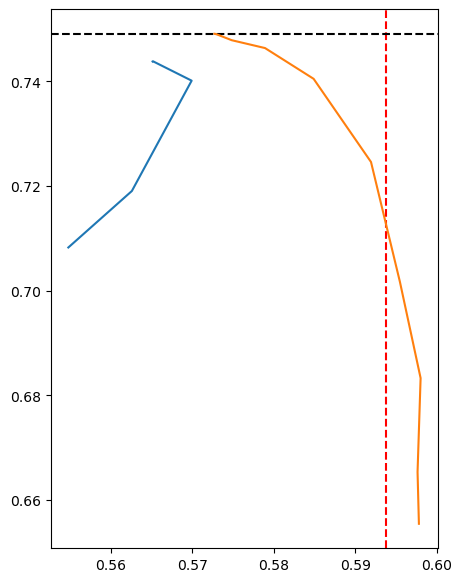

In [66]:
fig, ax = plt.subplots(figsize=(5,7))

ax.axvline(x=optimal_active_rate, color='red', linestyle='--',label='Optimal Active')

# Plot the horizontal dashed line
ax.axhline(y=np.mean(optimal_match_reward), color='black', linestyle='--',label='Optimal Match')

plt.plot(approximate_active,approximate_match)
plt.plot(joint_active,joint_match)

In [21]:
data = {
    'mean_reward': rewards_by_lamb, 
    'std_reward': std_by_lamb,
    'active_rate': active_rates_by_lamb, 
    'parameters': 
        {'seed'      : seed,
        'n_arms'    : n_arms,
        'budget'    : budget,
        'discount'  : discount, 
        'alpha'     : alpha, 
        'n_episodes': n_episodes, 
        'episode_len': episode_len, 
        'n_epochs'  : n_epochs, 
        'match_prob': match_prob} 
}

In [23]:
save_path = get_save_path('matching',save_name,seed,use_date=save_with_date)

In [24]:
delete_duplicate_results('matching',save_name,data)

In [25]:
json.dump(data,open('../results/'+save_path,'w'))